The discrete convolution:
$$
\partial_t^\alpha (t_n) = \frac{1}{\tau^\alpha} \sum_{j=1}^{n+1} \omega_j^\alpha \Big[u(t_{n-j+1}) - u(0)  \Big]
$$
with 
<!-- $$ -->
<!-- \omega_0^\alpha = 1; \quad \omega_j^\alpha = - \frac{\alpha -j + 1}{j}, \quad j=1,\ldots . -->
<!-- $$ -->

$$
\omega_1^\alpha = 1; \quad \omega_j^\alpha = \frac{j-α-2}{j-1} ω_{j-1}^α, \quad j=2,\ldots .
$$

The following scheme is implemented:

$$
 \displaystyle \left(\frac{1}{τ^α} ω_1 M + A\right)u^n = f^n + \frac{1}{τ^α} \sum_{j=1}^{n} ω_j M u^1 - \frac{1}{τ^α} \sum_{j=2}^{n} ω_{n-j+1} M u^{j}
$$

In [1]:
module FractionalCDRConvQuadFEM
  using GradientRobustMultiPhysics
  using ExtendableGrids
  using GridVisualize
  using ExtendableSparse
  using SpecialFunctions

  """
    ReactionConvectionDiffusionOperator(α, β, ϵ)

    TBW
  """
  function ReactionConvectionDiffusionOperator(γ, β, ϵ)
    function action_kernel!(result, input, x, t)
        β.x = x
        β.time = t
        eval_data!( γ )
        eval_data!( β )
        # α * u_h + β_1 * ∇_xu_h + β_2 ∇_y u_h
        result[1] = γ.val[1] * input[1] + β.val[1] * input[2] + β.val[2] * input[3]
        # Laplacian
        result[2] = ϵ * input[2]
        result[3] = ϵ * input[3]
        return nothing
    end
    action = Action(action_kernel!, [3, 3], dependencies = "XT", bonus_quadorder = max(γ.bonus_quadorder, β.bonus_quadorder))
    return BilinearForm([OperatorPair{Identity, Gradient}, OperatorPair{Identity, Gradient}], action;
    name=" ϵ(∇ u, ∇ v) + (γ u + β⋅∇u, v)", transposed_assembly = true)
  end

  """
    get_problem_data(ν)

  TBW
  """
  function boundary_layer(ϵ, p=1.0, α=1.0)
    γ = DataFunction([1.0]; name = "γ")
    β = DataFunction([2.0,3.0]; name = "β")
    function exact!(result, x, t)
      expx =exp(2*(x[1]-1)*ϵ);
      expy =exp(3*(x[2]-1)*ϵ);
      expxy=exp((2*(x[1]-1)+3*(x[2]-1))*ϵ);
      # u = x[1]*x[2]^2-x[2]^2*expx-x[1]*expy+expxy;
      result[1] = (x[1]*x[2]^2-x[2]^2*expx-x[1]*expy+expxy)* (t^(p+1)+t^p);
    end 
    u = DataFunction(exact!, [1,2]; name="u", dependencies="XT", bonus_quadorder=5)
    function exact_ut!(result, x, t)
      expx =exp(2*(x[1]-1)*ϵ);
      expy =exp(3*(x[2]-1)*ϵ);
      expxy=exp((2*(x[1]-1)+3*(x[2]-1))*ϵ);      
      result[1] = (x[1]*x[2]^2-x[2]^2*expx-x[1]*expy+expxy)* (gamma(p+1)/gamma(p-α+1)*t^(p-α)+gamma(p+2)/gamma(p+1-α+1)*t^(p+1-α));
    end 
    dtu = DataFunction(exact_ut!, [1,2]; name="u", dependencies="XT", bonus_quadorder=5)    
    ∇u = eval_∇(u)
    Δu = eval_Δ(u)
    function rhs!(result, x, t)
        result[1] = dtu(x,t)[1] - ϵ*Δu(x,t)[1] + dot(β(), ∇u(x,t))[1] + dot(γ(), u(x,t)[1]) # γ * u(x,t)[1]
      return nothing
    end
    f = DataFunction(rhs!, [1,2]; name = "f", dependencies = "XT", bonus_quadorder = 5)
    return γ, β, u, ∇(u), f
  end
  # example 
  function get_problem_data(ϵ, p=1.0, α=1.0)
    γ = DataFunction([1.0]; name = "γ")
    β = DataFunction([1.0,2.0]; name = "β")    
    function exact!(result, x, t)
        result[1] = x[1]*t^p
     end
    
    u = DataFunction(exact!, [1,2]; name="u", dependencies="XT", bonus_quadorder=5)
    dt_u = eval_dt(u)
    ∇u = eval_∇(u)
    Δu = eval_Δ(u)
    function rhs!(result, x, t)    
        dt_u = x[1] * gamma(p+1)/gamma(p-α+1)*t^(p-α)
        result[1] = dt_u-ϵ*Δu(x,t)[1] + dot(β(), ∇u(x,t))[1] + dot(γ(), u(x,t)[1]) # γ * u(x,t)[1]
      return nothing
    end
    f = DataFunction(rhs!, [1,2]; name = "f", dependencies = "XT", bonus_quadorder = 5)
    return γ, β, u, ∇(u), f
  end 
  
  function main(; ϵ=1.0, nrefinements=2, order=1, nsteps=10, Tf=1.0, α=1, tpower=1.0, verbosity=0, stab_param = 1e-2)
    ω = zeros(nsteps+1)
    ω[1] = 1.0
    ω[2] = -α
    for j=3:nsteps+1
        ω[j] = (j-2-α)/(j-1)*ω[j-1]
    end
    # @show ω
    # computing the sum of ω
    sum_omega = zeros(nsteps+1)
    sum_omega[1] = ω[1]
    for j=2:nsteps+1
        sum_omega[j] = sum_omega[j-1] + ω[j]
    end
    # @show  sum_omega;

    ## finite elements and bilinear forms
    # Prepare the matrices and rhs coming from space discretization 
    ## set log level
    set_verbosity(verbosity)    
    ## negotiate data functions to the package
    γ, β, u, ∇u, f = boundary_layer(ϵ, tpower, α)
    # choose a finite element type
    FEType = H1Pk{1,2,order}
    xgrid = uniform_refine(grid_unitsquare(Triangle2D), nrefinements)
    FES = FESpace{FEType}(xgrid)
    Solution = FEVector(FES)
    n_dofs = FES.ndofs
    interpolate!(Solution[1], u; time = 0.0)    

    M = FEMatrix(FES)
    assemble_operator!(M[1,1], BilinearForm([Identity, Identity]))
    # @show M.entries
    # println(size(M[1,1]))
    @show FES.ndofs
    A = FEMatrix(FES)
    assemble_operator!(A[1,1], ReactionConvectionDiffusionOperator(γ, β, ϵ); time=0.0)
    # @show A.entries

    if stab_param > 0 
      xFaceVolumes = xgrid[FaceVolumes]
      xFaceVolumes::Array{Float64,1} = xgrid[FaceVolumes]
      stab_action = Action((result,input,item) -> (result .= input .* xFaceVolumes[item[1]]^2), [2,2]; name = "stabilisation action", dependencies = "I")
      JumpStabilisation = BilinearForm([Jump(Gradient), Jump(Gradient)], stab_action; AT = ON_IFACES, factor = stab_param, name = "τ |F|^2 [∇(#A)]⋅[∇(#T)]")
      S = FEMatrix(FES)
      assemble_operator!(S[1,1], JumpStabilisation)
    end

    rhs = FEVector(FES)
    assemble_operator!(rhs[1], LinearForm(Identity, f); time=0.0)
    # @show rhs.entries

    dt = Array{BoundaryData,1}(undef,0)
    push!(dt, BoundaryData(BestapproxDirichletBoundary; regions = [1,2,3,4], data = u))
    dofs = boundarydata!(Solution[1], dt; time = 0.0)
    
    t0 = 0.0
    tau = (Tf - t0)/nsteps
    @show nrefinements, nsteps

    V1 = zeros(Float64, FES.ndofs, 1)
    Mu0 = zeros(Float64, FES.ndofs)
    temp = zeros(Float64, FES.ndofs, nsteps)    
    temp[:, 1] = Solution[1].entries

    SystemMatrix = FEMatrix(FES)
    # @show SystemMatrix
    SystemRHS = FEVector(FES)
    SystemSol = FEVector(FES)

    # SolVector = Array{FEVector{Float64}}([])
    Sols = Array{FEVector}(undef, nsteps)
    # push!(SolVector, Solution)

    scale = tau^α
    l2 = zero(Float64); h1=zeros(Float64)
    oldL2 = zero(Float64); oldh1 = zero(Float64)
    eL2 = zero(Float64); eH1 = zero(Float64)
    l2max=zero(Float64)
    for m=2:nsteps
      t0 = t0+tau
      fill!(SystemRHS.entries, 0)
      fill!(rhs.entries, 0)
      assemble_operator!(rhs[1], LinearForm(Identity, f), time= t0 )
      V1[:, 1] = rhs.entries
      addblock!(SystemRHS[1], V1[:,1]; factor= 1.0 )
      # @show ω[m-1]
      addblock!(SystemRHS[1], Mu0; factor= sum_omega[m-1]/scale)
      for j=2:m-1
        # println(m," ", j, " ", m-j+1, " ", bj[m-j+1])
        addblock!(SystemRHS[1], M.entries*temp[:,j]; factor= -ω[m-j+1]/scale)
      end

      fill!(SystemMatrix.entries.cscmatrix.nzval, 0)
      fill!(A.entries.cscmatrix.nzval, 0)
      # assembling the matrices with coefficients depending on time     
      assemble_operator!(A[1, 1], ReactionConvectionDiffusionOperator(γ, β, ϵ); time=t0 )
      if stab_param > 0 
        fill!(S.entries.cscmatrix.nzval, 0)
        assemble_operator!(S[1,1], JumpStabilisation; time=t0)
        addblock!(SystemMatrix[1,1], S[1,1]; factor = 1.0)
      end
      addblock!(SystemMatrix[1, 1], M[1, 1]; factor= 1.0/scale)
      addblock!(SystemMatrix[1, 1], A[1, 1]; factor= 1.0)

      flush!(SystemMatrix.entries)      
      #@show SystemRHS.entries
      dofs = boundarydata!(SystemSol[1], dt; time = t0)        
      for dof in dofs
        SystemRHS[1][dof] = 1e60 * SystemSol[1][dof]
        SystemMatrix[1,1][dof,dof] = 1e60
      end
      SystemSol.entries[:] = SystemMatrix.entries \ SystemRHS.entries
      for j = 1 : n_dofs 
        Solution[1][j] = SystemSol[1][j]
      end
      # push!(SolVector, Solution)
      temp[:, m] = Solution[1].entries

      L2Error_u = L2ErrorIntegrator(u, Identity; time= t0)
      l2 = evaluate(L2Error_u, Solution[1])
      eL2 += (l2 + oldL2) * tau * 0.5
      oldL2 = l2
      l2max = max(l2max, l2)
      h1erro = L2ErrorIntegrator(∇(u), Gradient; time= t0)
      h1 = evaluate(h1erro, Solution[1])
      eH1 += (l2 + oldh1) * tau * 0.5
      oldh1 = h1
      # @show (sqrt(eL2), sqrt(eh1))
    end #endfor time 
    @show (sqrt(l2), sqrt(h1), sqrt(l2max), sqrt(eL2), sqrt(eH1))
    (sqrt(l2), sqrt(h1), sqrt(l2max), sqrt(eL2), sqrt(eH1))
  end #end main 
end #module 

Main.FractionalCDRConvQuadFEM

In [6]:
ns = [10 20 40 80]
ns = [ 4 5]
eL2=[]; eH1=[]; L2Max=[]; L2=[]; H1=[]
for n in ns
    l2, h1, l2m, el2, eh1 = Main.FractionalCDRConvQuadFEM.main(;ϵ=1e-5, nrefinements=n, order=1, nsteps=1000, α=0.7, tpower=2, stab_param=1.0)
    push!(L2, l2)
    push!(H1, h1)
    push!(L2Max, l2m)
    push!(eL2, el2)
    push!(eH1, eh1)
end

FES.ndofs = 545
(nrefinements, nsteps) = 

(4, 1000)


(sqrt(l2), sqrt(h1), sqrt(l2max), sqrt(eL2), sqrt(eH1)) = (0.002324212944780121, 0.0618499025383129, 0.002324212944780121, 0.0009380444159853751, 0.01791423769167514)
FES.ndofs = 2113


L2: Any[0.12942188428026766, 0.025432718440049833, 0.008165064051229813, 0.002513065292594538, 0.0007199115476201217, 0.00024381977773672197]
H1: Any[0.8877602413994173, 0.4636510899182173, 0.23279685858997265, 0.11510291680665458, 0.05693106634471299, 0.028352618660813716]
L2Max: Any[0.12942188428026766, 0.025432718440049833, 0.008165064051229813, 0.002513065292594538, 0.0007199115476201217, 0.00024381977773672197]
L2(L2): Any[0.05254505810848674, 0.010421825095789266, 0.003315673967987785, 0.00101886929538354, 0.00029821500094496064, 0.0001176319658244242]
L2(H1): Any[0.2591871121393015, 0.13468279610635014, 0.06751448213902646, 0.033381793387694945, 0.016521294401777843, 0.008253004692669604]


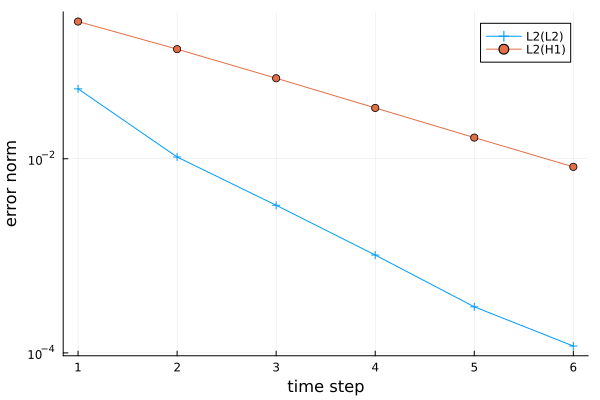

In [5]:
using Plots
println("L2: ", L2)
println("H1: ", H1)
println("L2Max: ", L2Max)
println("L2(L2): ", eL2)
println("L2(H1): ", eH1)
taus = [ 1,2,3,4,5,6]
plot(taus,[eL2 eH1],
    yaxis=:log10,
    label=["L2(L2)" "L2(H1)"],
    shape=:auto,
    xlabel="time step",ylabel="error norm")